<a href="https://colab.research.google.com/github/RenataKostolina/Machine_learning/blob/main/tuning_and_shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <a href="https://girafe.ai/" target="_blank" rel="noopener noreferrer"><img src="https://raw.githubusercontent.com/girafe-ai/ml-course/7096a5df4cada5ee651be1e3215c2f7fb8a7e0bf/logo_margin.svg" alt="girafe-ai logo" width="150px" align="left"></a> [ml-basic course](https://github.com/girafe-ai/ml-course) <a class="tocSkip">

# Lab assignment №1, part 2
## Gradient boosting on temporal data and feature importances

Today we will work with Gradient Boosting library. It is one of the most popular models these days that shows both great quality and performance.

Choises for library are:

* [LightGBM](https://github.com/Microsoft/LightGBM) by Microsoft. Handful and fast.
* [Catboost](https://github.com/catboost/catboost) by Yandex. Tuned to deal well with categorical features.
* [xgboost](https://github.com/dmlc/xgboost) by dlmc. The most famous framework which got very popular on kaggle.

**Dataset**

By default we will work with widely known [Human Actividy Recognition (HAR) dataset](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones). Data is available at UCI repository.

There are available both raw and preprocessed datasets. This time we will use the preprocessed one.
Some simple preprocessing is done for you.

If you want more interpretable data, you can take [Wine quality dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) (see details below).

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset and try to get some useful insights on the features the model paid attention to.

_Despite the main language of this notebook is English, feel free to write your thoughts in Russian._

## Part 0. Downloading and preprocessing

The preprocessing is done for you. Let's take a look at the data:

In [ ]:
# Download and unpack dataset from UCI
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip -u "UCI HAR Dataset.zip" "UCI HAR Dataset/train/X_train.txt" "UCI HAR Dataset/train/y_train.txt" \
"UCI HAR Dataset/test/X_test.txt" "UCI HAR Dataset/test/y_test.txt" "UCI HAR Dataset/activity_labels.txt"

--2024-11-14 13:17:26--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip     [        <=>         ]  58.17M  37.2MB/s    in 1.6s    

2024-11-14 13:17:28 (37.2 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314]

Archive:  UCI HAR Dataset.zip
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: UCI HAR Dataset/test/X_test.txt  
  inflating: UCI HAR Dataset/test/y_test.txt  
  inflating: UCI HAR Dataset/train/X_train.txt  
  inflating: UCI HAR Dataset/train/y_train.txt  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
X_train = np.genfromtxt("UCI HAR Dataset/train/X_train.txt")
y_train = np.genfromtxt("UCI HAR Dataset/train/y_train.txt")
print(f"Train set: {X_train.shape}, {y_train.shape}")

X_test = np.genfromtxt("UCI HAR Dataset/test/X_test.txt")
y_test = np.genfromtxt("UCI HAR Dataset/test/y_test.txt")
print(f"Test set: {X_test.shape}, {y_test.shape}")

n_features = X_train.shape[1]

Train set: (7352, 561), (7352,)
Test set: (2947, 561), (2947,)


In [ ]:
activity_labels = {}
with open("UCI HAR Dataset/activity_labels.txt", "r") as file:
    for line in file:
        label, name = line.strip().split(" ")
        activity_labels[int(label)] = name

activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

Let's normalize data

In [ ]:
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean) / data_std
X_test = (X_test - data_mean) / data_std

The dataset has some duplicating features. Let's remove them

In [ ]:
# fmt: off
duplicating_columns = (
    205, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 231, 244, 257, 507, 520, 533, 546,
)
# fmt: on

duplicating_mask = np.isin(range(n_features), duplicating_columns)

In [ ]:
X_train_unique = X_train[:, ~duplicating_mask]
X_test_unique = X_test[:, ~duplicating_mask]

X_train_unique.shape, X_test_unique.shape

((7352, 540), (2947, 540))

PCA could be useful in this case. E.g.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(0.99)

X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

X_train_pca.shape, X_test_pca.shape

((7352, 179), (2947, 179))

Text(0, 0.5, 'Principal component 2')

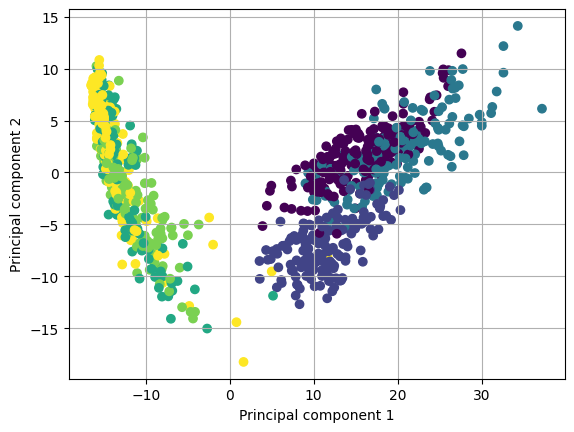

In [ ]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")

Text(0, 0.5, 'Principal component 5')

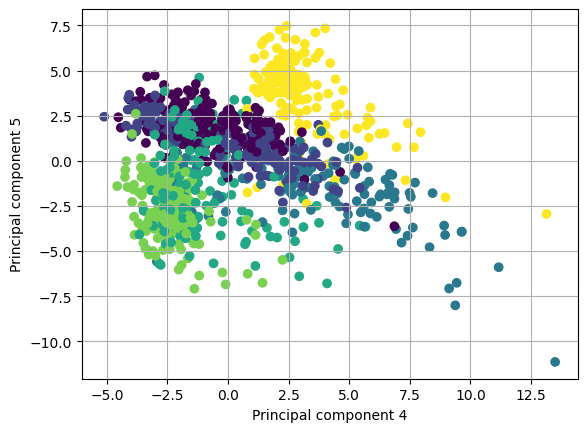

In [ ]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 4")
plt.ylabel("Principal component 5")

## Part 1. Fit the model.

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to approximate them by yourself.

In this part just check some (3-5) sets of hyperparameters by hand.

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.3 MB/s eta 0:00:00


Для начала попробуем запустить модель со стандартными параметрами

In [ ]:
# YOUR CODE HERE
model = CatBoostClassifier()
model.fit(X_train_pca, y_train, verbose=False)

In [ ]:
accuracy = model.score(X_test_pca, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9375636240244316


Теперь подберем гиперпараметры вручную

In [ ]:
new_model = CatBoostClassifier(iterations=200, learning_rate=0.1, random_strength=3.0, depth=6)
new_model.fit(X_train_pca, y_train, verbose=False)
new_accuracy = new_model.score(X_test_pca, y_test)
print(f"Accuracy: {new_accuracy}")

Accuracy: 0.9189005768578216


In [ ]:
new_model = CatBoostClassifier(iterations=200, learning_rate=0.3, random_strength=3.0, depth=7)
new_model.fit(X_train_pca, y_train, verbose=False)
new_accuracy = new_model.score(X_test_pca, y_test)
print(f"Accuracy: {new_accuracy}")

Accuracy: 0.9334916864608076


In [ ]:
new_model = CatBoostClassifier(iterations=1000, learning_rate=0.35, random_strength=3.0, depth=7)
new_model.fit(X_train_pca, y_train, verbose=False)
new_accuracy = new_model.score(X_test_pca, y_test)
print(f"Accuracy: {new_accuracy}")

Accuracy: 0.9440108585001696


Результаты печальные, но, как известно, catboost изначально дает лучшие результаты со стандартными параметрами в сравнении с другими, однако последующее улучшение идет значительно сложнее.

## Part 2. Use hyper parameter tuning system

Use [optuna](https://optuna.org/), [hyperopt](http://hyperopt.github.io/hyperopt/) or any other zero order optimizer to find optimal hyper param set.

In [ ]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00


In [ ]:
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.35, 0.001)
    param['depth'] = trial.suggest_int('depth', 6, 15)
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['grow_policy'] = trial.suggest_categorical('grow_policy', ['Depthwise', 'SymmetricTree', 'Lossguide'])
    param['random_strength'] = trial.suggest_discrete_uniform('random_strength', 0.5, 5, 0.1)
    param['iterations'] = 50
    param['use_best_model'] = True
    param['random_state'] = 42

    classifier = CatBoostClassifier(**param)

    classifier.fit(X_train_pca.copy(), y_train.copy(),
                  eval_set=[(X_test_pca.copy(), y_test.copy())], verbose=25)

    return  classifier.score(X_test_pca.copy(), y_test.copy())

Подберем гиперпараметры для модели по метрике accuracy с помощью optuna максимизацией на небольшом числе итераций для ускорения процесса, но большим числом процессов

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(study.best_params)

[I 2024-11-12 09:37:25,996] A new study created in memory with name: no-name-59c465ba-e4c7-4f7f-9112-f057a06b3136
<ipython-input-23-79f9dcf0d96d>:3: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.35, 0.001)
<ipython-input-23-79f9dcf0d96d>:5: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
<ipython-input-23-79f9dcf0d96d>:8: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugge

0:	learn: 1.6096869	test: 1.6311099	best: 1.6311099 (0)	total: 3.25s	remaining: 2m 39s
25:	learn: 0.4625251	test: 0.6484229	best: 0.6484229 (25)	total: 1m 37s	remaining: 1m 29s
49:	learn: 0.2770654	test: 0.5088548	best: 0.5088548 (49)	total: 3m 4s	remaining: 0us

bestTest = 0.5088548442
bestIteration = 49



[I 2024-11-12 09:40:31,601] Trial 0 finished with value: 0.8622327790973872 and parameters: {'learning_rate': 0.17600000000000002, 'depth': 10, 'l2_leaf_reg': 5.0, 'min_child_samples': 4, 'grow_policy': 'SymmetricTree', 'random_strength': 4.8}. Best is trial 0 with value: 0.8622327790973872.


0:	learn: 1.4629911	test: 1.4772008	best: 1.4772008 (0)	total: 337ms	remaining: 16.5s
25:	learn: 0.3360725	test: 0.4332243	best: 0.4332243 (25)	total: 8.69s	remaining: 8.02s


[I 2024-11-12 09:40:50,735] Trial 1 finished with value: 0.8798778418730913 and parameters: {'learning_rate': 0.132, 'depth': 7, 'l2_leaf_reg': 2.0, 'min_child_samples': 16, 'grow_policy': 'Lossguide', 'random_strength': 1.0}. Best is trial 1 with value: 0.8798778418730913.


49:	learn: 0.2259480	test: 0.3491831	best: 0.3491831 (49)	total: 17.7s	remaining: 0us

bestTest = 0.349183141
bestIteration = 49

0:	learn: 1.7810019	test: 1.7835825	best: 1.7835825 (0)	total: 23s	remaining: 18m 49s
25:	learn: 1.5152743	test: 1.5731991	best: 1.5731991 (25)	total: 9m 40s	remaining: 8m 56s
49:	learn: 1.3171388	test: 1.4165578	best: 1.4165578 (49)	total: 18m 38s	remaining: 0us

bestTest = 1.416557819
bestIteration = 49



[I 2024-11-12 09:59:30,266] Trial 2 finished with value: 0.7923311842551748 and parameters: {'learning_rate': 0.010000000000000002, 'depth': 12, 'l2_leaf_reg': 2.5, 'min_child_samples': 16, 'grow_policy': 'SymmetricTree', 'random_strength': 2.3}. Best is trial 1 with value: 0.8798778418730913.


0:	learn: 1.5012275	test: 1.5113588	best: 1.5113588 (0)	total: 369ms	remaining: 18.1s
25:	learn: 0.4017237	test: 0.4928155	best: 0.4928155 (25)	total: 11.1s	remaining: 10.3s


[I 2024-11-12 09:59:52,004] Trial 3 finished with value: 0.8703766542246352 and parameters: {'learning_rate': 0.132, 'depth': 10, 'l2_leaf_reg': 1.5, 'min_child_samples': 4, 'grow_policy': 'Lossguide', 'random_strength': 1.9000000000000001}. Best is trial 1 with value: 0.8798778418730913.


49:	learn: 0.2894492	test: 0.4088978	best: 0.4088978 (49)	total: 20.8s	remaining: 0us

bestTest = 0.4088977934
bestIteration = 49

0:	learn: 1.4743098	test: 1.5293878	best: 1.5293878 (0)	total: 4s	remaining: 3m 15s
25:	learn: 0.1672676	test: 0.4573367	best: 0.4573367 (25)	total: 1m 48s	remaining: 1m 40s
49:	learn: 0.0519329	test: 0.3251972	best: 0.3251972 (49)	total: 2m 52s	remaining: 0us

bestTest = 0.325197238
bestIteration = 49



[I 2024-11-12 10:02:45,800] Trial 4 finished with value: 0.8822531387852053 and parameters: {'learning_rate': 0.251, 'depth': 12, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'grow_policy': 'Depthwise', 'random_strength': 0.8}. Best is trial 4 with value: 0.8822531387852053.


0:	learn: 1.3118303	test: 1.3479411	best: 1.3479411 (0)	total: 619ms	remaining: 30.3s
25:	learn: 0.2056990	test: 0.3679090	best: 0.3679090 (25)	total: 17.4s	remaining: 16.1s
49:	learn: 0.1197163	test: 0.3013457	best: 0.3013457 (49)	total: 31s	remaining: 0us

bestTest = 0.3013456848
bestIteration = 49



[I 2024-11-12 10:03:17,942] Trial 5 finished with value: 0.8998982015609094 and parameters: {'learning_rate': 0.20900000000000002, 'depth': 7, 'l2_leaf_reg': 4.0, 'min_child_samples': 4, 'grow_policy': 'Depthwise', 'random_strength': 1.0}. Best is trial 5 with value: 0.8998982015609094.


0:	learn: 1.6112552	test: 1.6223194	best: 1.6223194 (0)	total: 1.63s	remaining: 1m 19s
25:	learn: 0.4714164	test: 0.6036694	best: 0.6036694 (25)	total: 35.9s	remaining: 33.1s
49:	learn: 0.2807086	test: 0.4513407	best: 0.4513407 (49)	total: 1m 7s	remaining: 0us

bestTest = 0.4513407023
bestIteration = 49



[I 2024-11-12 10:04:27,474] Trial 6 finished with value: 0.8741092636579573 and parameters: {'learning_rate': 0.108, 'depth': 9, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'grow_policy': 'Depthwise', 'random_strength': 2.2}. Best is trial 5 with value: 0.8998982015609094.


0:	learn: 1.6890590	test: 1.7079392	best: 1.7079392 (0)	total: 6.21s	remaining: 5m 4s
25:	learn: 0.7438714	test: 0.9745675	best: 0.9745675 (25)	total: 3m 11s	remaining: 2m 57s
49:	learn: 0.4647048	test: 0.7675076	best: 0.7675076 (49)	total: 6m 9s	remaining: 0us

bestTest = 0.7675075849
bestIteration = 49



[I 2024-11-12 10:10:38,656] Trial 7 finished with value: 0.842212419409569 and parameters: {'learning_rate': 0.08700000000000001, 'depth': 13, 'l2_leaf_reg': 3.5, 'min_child_samples': 4, 'grow_policy': 'Depthwise', 'random_strength': 4.7}. Best is trial 5 with value: 0.8998982015609094.


0:	learn: 1.6531661	test: 1.6649733	best: 1.6649733 (0)	total: 742ms	remaining: 36.3s
25:	learn: 0.6231163	test: 0.7209226	best: 0.7209226 (25)	total: 20.9s	remaining: 19.3s


[I 2024-11-12 10:11:21,303] Trial 8 finished with value: 0.8513742789277231 and parameters: {'learning_rate': 0.09, 'depth': 8, 'l2_leaf_reg': 4.5, 'min_child_samples': 1, 'grow_policy': 'SymmetricTree', 'random_strength': 4.6000000000000005}. Best is trial 5 with value: 0.8998982015609094.


49:	learn: 0.4446742	test: 0.5700241	best: 0.5700241 (49)	total: 41.7s	remaining: 0us

bestTest = 0.57002414
bestIteration = 49

0:	learn: 1.6290603	test: 1.6557574	best: 1.6557574 (0)	total: 4.09s	remaining: 3m 20s
25:	learn: 0.3931641	test: 0.6463568	best: 0.6463568 (25)	total: 1m 45s	remaining: 1m 37s
49:	learn: 0.1786619	test: 0.4685623	best: 0.4685623 (49)	total: 3m 19s	remaining: 0us

bestTest = 0.4685622954
bestIteration = 49



[I 2024-11-12 10:14:41,405] Trial 9 finished with value: 0.8680013573125213 and parameters: {'learning_rate': 0.08800000000000001, 'depth': 15, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'grow_policy': 'Depthwise', 'random_strength': 2.4000000000000004}. Best is trial 5 with value: 0.8998982015609094.


0:	learn: 1.2788597	test: 1.2879029	best: 1.2879029 (0)	total: 334ms	remaining: 16.3s
25:	learn: 0.2917144	test: 0.4149393	best: 0.4149393 (25)	total: 10.2s	remaining: 9.46s


[I 2024-11-12 10:14:59,800] Trial 10 finished with value: 0.9019341703427214 and parameters: {'learning_rate': 0.31, 'depth': 6, 'l2_leaf_reg': 4.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 3.6}. Best is trial 10 with value: 0.9019341703427214.


49:	learn: 0.1178108	test: 0.2834702	best: 0.2834702 (49)	total: 17.4s	remaining: 0us

bestTest = 0.2834702006
bestIteration = 49

0:	learn: 1.2336979	test: 1.2435499	best: 1.2435499 (0)	total: 340ms	remaining: 16.7s
25:	learn: 0.2750877	test: 0.4312307	best: 0.4312307 (25)	total: 10.3s	remaining: 9.52s


[I 2024-11-12 10:15:19,566] Trial 11 finished with value: 0.8954869358669834 and parameters: {'learning_rate': 0.342, 'depth': 6, 'l2_leaf_reg': 3.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 3.5}. Best is trial 10 with value: 0.9019341703427214.


49:	learn: 0.1023474	test: 0.2891889	best: 0.2891889 (49)	total: 18.8s	remaining: 0us

bestTest = 0.2891889129
bestIteration = 49

0:	learn: 1.3009918	test: 1.3097336	best: 1.3097336 (0)	total: 343ms	remaining: 16.8s
25:	learn: 0.3093015	test: 0.4522069	best: 0.4522069 (25)	total: 9.73s	remaining: 8.99s


[I 2024-11-12 10:15:38,474] Trial 12 finished with value: 0.8951476077366813 and parameters: {'learning_rate': 0.293, 'depth': 6, 'l2_leaf_reg': 4.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 3.4000000000000004}. Best is trial 10 with value: 0.9019341703427214.


49:	learn: 0.1278241	test: 0.3039579	best: 0.3039579 (49)	total: 17.9s	remaining: 0us

bestTest = 0.3039579225
bestIteration = 49

0:	learn: 1.3864224	test: 1.4053487	best: 1.4053487 (0)	total: 669ms	remaining: 32.8s
25:	learn: 0.3074416	test: 0.4827081	best: 0.4827081 (25)	total: 20.7s	remaining: 19.1s


[I 2024-11-12 10:16:16,835] Trial 13 finished with value: 0.8859857482185273 and parameters: {'learning_rate': 0.234, 'depth': 8, 'l2_leaf_reg': 3.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 3.5}. Best is trial 10 with value: 0.9019341703427214.


49:	learn: 0.1181493	test: 0.3198761	best: 0.3198761 (49)	total: 37.4s	remaining: 0us

bestTest = 0.319876131
bestIteration = 49

0:	learn: 1.1045974	test: 1.1223545	best: 1.1223545 (0)	total: 371ms	remaining: 18.2s
25:	learn: 0.1840590	test: 0.3463921	best: 0.3463921 (25)	total: 11.4s	remaining: 10.5s


[I 2024-11-12 10:16:39,727] Trial 14 finished with value: 0.8975229046487954 and parameters: {'learning_rate': 0.342, 'depth': 6, 'l2_leaf_reg': 4.0, 'min_child_samples': 1, 'grow_policy': 'Depthwise', 'random_strength': 1.4}. Best is trial 10 with value: 0.9019341703427214.


49:	learn: 0.0923837	test: 0.2785926	best: 0.2785926 (49)	total: 21.9s	remaining: 0us

bestTest = 0.2785926367
bestIteration = 49

0:	learn: 1.3934700	test: 1.4071857	best: 1.4071857 (0)	total: 353ms	remaining: 17.3s
25:	learn: 0.3931706	test: 0.4770933	best: 0.4770933 (25)	total: 9.87s	remaining: 9.11s


[I 2024-11-12 10:16:58,965] Trial 15 finished with value: 0.8832711231761113 and parameters: {'learning_rate': 0.20900000000000002, 'depth': 8, 'l2_leaf_reg': 3.0, 'min_child_samples': 8, 'grow_policy': 'Lossguide', 'random_strength': 3.0}. Best is trial 10 with value: 0.9019341703427214.


49:	learn: 0.2430491	test: 0.3685640	best: 0.3685640 (49)	total: 18.3s	remaining: 0us

bestTest = 0.3685640387
bestIteration = 49

0:	learn: 1.3245345	test: 1.3419867	best: 1.3419867 (0)	total: 500ms	remaining: 24.5s
25:	learn: 0.3425589	test: 0.4908951	best: 0.4908951 (25)	total: 14s	remaining: 12.9s


[I 2024-11-12 10:17:25,681] Trial 16 finished with value: 0.9026128266033254 and parameters: {'learning_rate': 0.28600000000000003, 'depth': 7, 'l2_leaf_reg': 4.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 4.0}. Best is trial 16 with value: 0.9026128266033254.


49:	learn: 0.1151374	test: 0.2940216	best: 0.2940216 (49)	total: 25.8s	remaining: 0us

bestTest = 0.294021604
bestIteration = 49

0:	learn: 1.3845892	test: 1.4337893	best: 1.4337893 (0)	total: 924ms	remaining: 45.3s
25:	learn: 0.3060519	test: 0.4917348	best: 0.4917348 (25)	total: 26.4s	remaining: 24.4s
49:	learn: 0.0938197	test: 0.3039546	best: 0.3039546 (49)	total: 48s	remaining: 0us

bestTest = 0.3039545787
bestIteration = 49



[I 2024-11-12 10:18:14,797] Trial 17 finished with value: 0.9019341703427214 and parameters: {'learning_rate': 0.28600000000000003, 'depth': 9, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 4.1}. Best is trial 16 with value: 0.9026128266033254.


0:	learn: 1.3587270	test: 1.3924948	best: 1.3924948 (0)	total: 416ms	remaining: 20.4s
25:	learn: 0.3291308	test: 0.4700531	best: 0.4700531 (25)	total: 11.9s	remaining: 11s
49:	learn: 0.1428521	test: 0.3021279	best: 0.3021279 (49)	total: 22.5s	remaining: 0us

bestTest = 0.3021279489
bestIteration = 49



[I 2024-11-12 10:18:38,367] Trial 18 finished with value: 0.8948082796063793 and parameters: {'learning_rate': 0.294, 'depth': 7, 'l2_leaf_reg': 4.5, 'min_child_samples': 32, 'grow_policy': 'SymmetricTree', 'random_strength': 4.1}. Best is trial 16 with value: 0.9026128266033254.


0:	learn: 1.3459575	test: 1.3797679	best: 1.3797679 (0)	total: 395ms	remaining: 19.3s
25:	learn: 0.3669900	test: 0.4720863	best: 0.4720863 (25)	total: 9.03s	remaining: 8.33s


[I 2024-11-12 10:18:58,136] Trial 19 finished with value: 0.8971835765184933 and parameters: {'learning_rate': 0.313, 'depth': 11, 'l2_leaf_reg': 4.5, 'min_child_samples': 32, 'grow_policy': 'Lossguide', 'random_strength': 4.0}. Best is trial 16 with value: 0.9026128266033254.


49:	learn: 0.1595302	test: 0.3015088	best: 0.3015088 (49)	total: 18.3s	remaining: 0us

bestTest = 0.3015088434
bestIteration = 49

0:	learn: 1.4164363	test: 1.4597277	best: 1.4597277 (0)	total: 1.89s	remaining: 1m 32s
25:	learn: 0.1884613	test: 0.4612667	best: 0.4612667 (25)	total: 56.9s	remaining: 52.5s
49:	learn: 0.0468317	test: 0.3176285	best: 0.3176285 (49)	total: 1m 48s	remaining: 0us

bestTest = 0.3176284835
bestIteration = 49



[I 2024-11-12 10:20:48,073] Trial 20 finished with value: 0.8924329826942654 and parameters: {'learning_rate': 0.254, 'depth': 15, 'l2_leaf_reg': 2.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 2.8000000000000003}. Best is trial 16 with value: 0.9026128266033254.


0:	learn: 1.4001555	test: 1.4473749	best: 1.4473749 (0)	total: 1.78s	remaining: 1m 27s
25:	learn: 0.3167576	test: 0.5210039	best: 0.5210039 (25)	total: 26.5s	remaining: 24.5s
49:	learn: 0.1000259	test: 0.3145122	best: 0.3145122 (49)	total: 48.2s	remaining: 0us

bestTest = 0.3145122125
bestIteration = 49



[I 2024-11-12 10:21:37,265] Trial 21 finished with value: 0.8975229046487954 and parameters: {'learning_rate': 0.273, 'depth': 9, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 4.1}. Best is trial 16 with value: 0.9026128266033254.


0:	learn: 1.3403813	test: 1.3634232	best: 1.3634232 (0)	total: 884ms	remaining: 43.3s
25:	learn: 0.2701599	test: 0.4816385	best: 0.4816385 (25)	total: 26.5s	remaining: 24.5s
49:	learn: 0.0712443	test: 0.2880013	best: 0.2880013 (49)	total: 44.5s	remaining: 0us

bestTest = 0.2880013497
bestIteration = 49



[I 2024-11-12 10:22:22,929] Trial 22 finished with value: 0.9022734984730234 and parameters: {'learning_rate': 0.317, 'depth': 9, 'l2_leaf_reg': 5.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 3.8000000000000003}. Best is trial 16 with value: 0.9026128266033254.


0:	learn: 1.2970744	test: 1.3157334	best: 1.3157334 (0)	total: 968ms	remaining: 47.4s
25:	learn: 0.2794056	test: 0.4369045	best: 0.4369045 (25)	total: 15.1s	remaining: 14s
49:	learn: 0.0988384	test: 0.2812972	best: 0.2812972 (49)	total: 24.7s	remaining: 0us

bestTest = 0.2812972183
bestIteration = 49



[I 2024-11-12 10:22:49,409] Trial 23 finished with value: 0.9029521547336274 and parameters: {'learning_rate': 0.313, 'depth': 7, 'l2_leaf_reg': 5.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 3.2}. Best is trial 23 with value: 0.9029521547336274.


0:	learn: 1.2739635	test: 1.2975175	best: 1.2975175 (0)	total: 1.29s	remaining: 1m 3s
25:	learn: 0.2248066	test: 0.4164212	best: 0.4164212 (25)	total: 19.9s	remaining: 18.4s
49:	learn: 0.0683977	test: 0.2762543	best: 0.2762543 (49)	total: 33s	remaining: 0us

bestTest = 0.2762543191
bestIteration = 49



[I 2024-11-12 10:23:24,078] Trial 24 finished with value: 0.9012555140821175 and parameters: {'learning_rate': 0.34900000000000003, 'depth': 8, 'l2_leaf_reg': 5.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 3.0}. Best is trial 23 with value: 0.9029521547336274.


0:	learn: 1.3048366	test: 1.3664621	best: 1.3664621 (0)	total: 521ms	remaining: 25.5s
25:	learn: 0.3211674	test: 0.5096177	best: 0.5096177 (25)	total: 13.9s	remaining: 12.8s


[I 2024-11-12 10:23:49,905] Trial 25 finished with value: 0.8863250763488293 and parameters: {'learning_rate': 0.326, 'depth': 7, 'l2_leaf_reg': 5.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 4.5}. Best is trial 23 with value: 0.9029521547336274.


49:	learn: 0.1022525	test: 0.3080235	best: 0.3080235 (49)	total: 24.9s	remaining: 0us

bestTest = 0.3080235075
bestIteration = 49

0:	learn: 1.3894734	test: 1.4117547	best: 1.4117547 (0)	total: 1.27s	remaining: 1m 2s
25:	learn: 0.2944559	test: 0.4962301	best: 0.4962301 (25)	total: 40s	remaining: 36.9s
49:	learn: 0.1131635	test: 0.3369507	best: 0.3369507 (49)	total: 1m 10s	remaining: 0us

bestTest = 0.3369507253
bestIteration = 49



[I 2024-11-12 10:25:01,574] Trial 26 finished with value: 0.8859857482185273 and parameters: {'learning_rate': 0.268, 'depth': 9, 'l2_leaf_reg': 4.5, 'min_child_samples': 8, 'grow_policy': 'Depthwise', 'random_strength': 3.8000000000000003}. Best is trial 23 with value: 0.9029521547336274.


0:	learn: 1.5183875	test: 1.5514138	best: 1.5514138 (0)	total: 4.53s	remaining: 3m 42s
25:	learn: 0.3655973	test: 0.5675116	best: 0.5675116 (25)	total: 1m 31s	remaining: 1m 24s


[I 2024-11-12 10:27:58,409] Trial 27 finished with value: 0.8744485917882593 and parameters: {'learning_rate': 0.224, 'depth': 10, 'l2_leaf_reg': 5.5, 'min_child_samples': 1, 'grow_policy': 'SymmetricTree', 'random_strength': 3.2}. Best is trial 23 with value: 0.9029521547336274.


49:	learn: 0.1847693	test: 0.4147486	best: 0.4147486 (49)	total: 2m 55s	remaining: 0us

bestTest = 0.4147486074
bestIteration = 49

0:	learn: 1.4510200	test: 1.4643222	best: 1.4643222 (0)	total: 368ms	remaining: 18s
25:	learn: 0.4037274	test: 0.4861957	best: 0.4861957 (25)	total: 10.1s	remaining: 9.3s
49:	learn: 0.2618947	test: 0.3686413	best: 0.3686413 (49)	total: 19s	remaining: 0us

bestTest = 0.3686413307
bestIteration = 49



[I 2024-11-12 10:28:18,375] Trial 28 finished with value: 0.8897183576518494 and parameters: {'learning_rate': 0.187, 'depth': 7, 'l2_leaf_reg': 5.0, 'min_child_samples': 32, 'grow_policy': 'Lossguide', 'random_strength': 2.7}. Best is trial 23 with value: 0.9029521547336274.


0:	learn: 1.3868427	test: 1.4477122	best: 1.4477122 (0)	total: 1.18s	remaining: 57.8s
25:	learn: 0.2918574	test: 0.5270316	best: 0.5270316 (25)	total: 31.5s	remaining: 29.1s
49:	learn: 0.0556105	test: 0.2933327	best: 0.2933327 (49)	total: 57.7s	remaining: 0us

bestTest = 0.2933326613
bestIteration = 49



[I 2024-11-12 10:29:17,099] Trial 29 finished with value: 0.8978622327790974 and parameters: {'learning_rate': 0.317, 'depth': 10, 'l2_leaf_reg': 4.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 5.0}. Best is trial 23 with value: 0.9029521547336274.


0:	learn: 1.5271949	test: 1.5563823	best: 1.5563823 (0)	total: 754ms	remaining: 36.9s
25:	learn: 0.4327149	test: 0.5686844	best: 0.5686844 (25)	total: 22.2s	remaining: 20.5s


[I 2024-11-12 10:29:59,652] Trial 30 finished with value: 0.8686800135731252 and parameters: {'learning_rate': 0.17, 'depth': 8, 'l2_leaf_reg': 5.0, 'min_child_samples': 32, 'grow_policy': 'SymmetricTree', 'random_strength': 3.8000000000000003}. Best is trial 23 with value: 0.9029521547336274.


49:	learn: 0.2833930	test: 0.4535469	best: 0.4535469 (49)	total: 41.6s	remaining: 0us

bestTest = 0.4535468769
bestIteration = 49

0:	learn: 1.3172562	test: 1.3758893	best: 1.3758893 (0)	total: 345ms	remaining: 16.9s
25:	learn: 0.3479273	test: 0.4914514	best: 0.4914514 (25)	total: 10.3s	remaining: 9.51s


[I 2024-11-12 10:30:19,617] Trial 31 finished with value: 0.8968442483881914 and parameters: {'learning_rate': 0.316, 'depth': 6, 'l2_leaf_reg': 4.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 4.4}. Best is trial 23 with value: 0.9029521547336274.


49:	learn: 0.1257723	test: 0.3008855	best: 0.3008855 (49)	total: 19s	remaining: 0us

bestTest = 0.3008854892
bestIteration = 49

0:	learn: 1.2891344	test: 1.2982568	best: 1.2982568 (0)	total: 340ms	remaining: 16.6s
25:	learn: 0.3170687	test: 0.4494946	best: 0.4494946 (25)	total: 9.89s	remaining: 9.13s


[I 2024-11-12 10:30:38,194] Trial 32 finished with value: 0.8988802171700034 and parameters: {'learning_rate': 0.298, 'depth': 6, 'l2_leaf_reg': 3.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 3.7}. Best is trial 23 with value: 0.9029521547336274.


49:	learn: 0.1234930	test: 0.2906849	best: 0.2906849 (49)	total: 17.6s	remaining: 0us

bestTest = 0.2906848785
bestIteration = 49

0:	learn: 1.3462412	test: 1.3631595	best: 1.3631595 (0)	total: 483ms	remaining: 23.7s
25:	learn: 0.3096257	test: 0.4585695	best: 0.4585695 (25)	total: 14.1s	remaining: 13s


[I 2024-11-12 10:31:05,319] Trial 33 finished with value: 0.8968442483881914 and parameters: {'learning_rate': 0.27, 'depth': 7, 'l2_leaf_reg': 4.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 3.3000000000000003}. Best is trial 23 with value: 0.9029521547336274.


49:	learn: 0.1171924	test: 0.3024924	best: 0.3024924 (49)	total: 26.2s	remaining: 0us

bestTest = 0.3024923726
bestIteration = 49

0:	learn: 1.2382754	test: 1.2915976	best: 1.2915976 (0)	total: 364ms	remaining: 17.8s
25:	learn: 0.3265254	test: 0.4635477	best: 0.4635477 (25)	total: 11.4s	remaining: 10.5s


[I 2024-11-12 10:31:27,785] Trial 34 finished with value: 0.8961655921275874 and parameters: {'learning_rate': 0.328, 'depth': 6, 'l2_leaf_reg': 4.0, 'min_child_samples': 4, 'grow_policy': 'Depthwise', 'random_strength': 4.300000000000001}. Best is trial 23 with value: 0.9029521547336274.


49:	learn: 0.1165023	test: 0.2976801	best: 0.2976801 (49)	total: 21.5s	remaining: 0us

bestTest = 0.2976801359
bestIteration = 49

0:	learn: 1.3514268	test: 1.3677901	best: 1.3677901 (0)	total: 346ms	remaining: 17s
25:	learn: 0.3936943	test: 0.4962015	best: 0.4962015 (25)	total: 10.1s	remaining: 9.29s


[I 2024-11-12 10:31:47,810] Trial 35 finished with value: 0.8802171700033933 and parameters: {'learning_rate': 0.246, 'depth': 7, 'l2_leaf_reg': 5.0, 'min_child_samples': 16, 'grow_policy': 'Lossguide', 'random_strength': 3.6}. Best is trial 23 with value: 0.9029521547336274.


49:	learn: 0.2092722	test: 0.3520314	best: 0.3520314 (49)	total: 19.1s	remaining: 0us

bestTest = 0.3520314001
bestIteration = 49

0:	learn: 1.4219308	test: 1.4499500	best: 1.4499500 (0)	total: 2.32s	remaining: 1m 53s
25:	learn: 0.2444766	test: 0.4759443	best: 0.4759443 (25)	total: 42.2s	remaining: 38.9s
49:	learn: 0.0533019	test: 0.3038544	best: 0.3038544 (49)	total: 1m 11s	remaining: 0us

bestTest = 0.3038544354
bestIteration = 49



[I 2024-11-12 10:33:00,739] Trial 36 finished with value: 0.8944689514760774 and parameters: {'learning_rate': 0.311, 'depth': 11, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 3.2}. Best is trial 23 with value: 0.9029521547336274.


0:	learn: 1.3274438	test: 1.3467932	best: 1.3467932 (0)	total: 861ms	remaining: 42.2s
25:	learn: 0.2926268	test: 0.4868803	best: 0.4868803 (25)	total: 26.2s	remaining: 24.2s
49:	learn: 0.0970045	test: 0.2970939	best: 0.2970939 (49)	total: 45.3s	remaining: 0us

bestTest = 0.2970939269
bestIteration = 49



[I 2024-11-12 10:33:46,989] Trial 37 finished with value: 0.8968442483881914 and parameters: {'learning_rate': 0.28300000000000003, 'depth': 8, 'l2_leaf_reg': 4.0, 'min_child_samples': 8, 'grow_policy': 'Depthwise', 'random_strength': 3.9000000000000004}. Best is trial 23 with value: 0.9029521547336274.


0:	learn: 1.3829985	test: 1.4131392	best: 1.4131392 (0)	total: 2.65s	remaining: 2m 9s
25:	learn: 0.2662639	test: 0.4748240	best: 0.4748240 (25)	total: 46.4s	remaining: 42.9s
49:	learn: 0.0990246	test: 0.3280654	best: 0.3280654 (49)	total: 1m 22s	remaining: 0us

bestTest = 0.3280653698
bestIteration = 49



[I 2024-11-12 10:35:10,551] Trial 38 finished with value: 0.8863250763488293 and parameters: {'learning_rate': 0.262, 'depth': 9, 'l2_leaf_reg': 4.5, 'min_child_samples': 4, 'grow_policy': 'Depthwise', 'random_strength': 2.7}. Best is trial 23 with value: 0.9029521547336274.


0:	learn: 1.6976913	test: 1.7045079	best: 1.7045079 (0)	total: 395ms	remaining: 19.4s
25:	learn: 0.8062965	test: 0.8792373	best: 0.8792373 (25)	total: 11.5s	remaining: 10.6s


[I 2024-11-12 10:35:33,094] Trial 39 finished with value: 0.827960637936885 and parameters: {'learning_rate': 0.054, 'depth': 7, 'l2_leaf_reg': 3.5, 'min_child_samples': 1, 'grow_policy': 'SymmetricTree', 'random_strength': 5.0}. Best is trial 23 with value: 0.9029521547336274.


49:	learn: 0.6055720	test: 0.6997278	best: 0.6997278 (49)	total: 21.6s	remaining: 0us

bestTest = 0.6997277821
bestIteration = 49

0:	learn: 1.7406311	test: 1.7501921	best: 1.7501921 (0)	total: 4.62s	remaining: 3m 46s
25:	learn: 0.9614450	test: 1.1122098	best: 1.1122098 (25)	total: 1m 26s	remaining: 1m 20s
49:	learn: 0.6230724	test: 0.8347688	best: 0.8347688 (49)	total: 2m 45s	remaining: 0us

bestTest = 0.83476883
bestIteration = 49



[I 2024-11-12 10:38:20,090] Trial 40 finished with value: 0.8445877163216831 and parameters: {'learning_rate': 0.024, 'depth': 13, 'l2_leaf_reg': 2.0, 'min_child_samples': 16, 'grow_policy': 'Depthwise', 'random_strength': 0.5}. Best is trial 23 with value: 0.9029521547336274.


0:	learn: 1.3716604	test: 1.4225148	best: 1.4225148 (0)	total: 935ms	remaining: 45.8s
25:	learn: 0.2920874	test: 0.4888283	best: 0.4888283 (25)	total: 29.9s	remaining: 27.6s
49:	learn: 0.0827951	test: 0.3065685	best: 0.3065685 (49)	total: 49.9s	remaining: 0us

bestTest = 0.3065685452
bestIteration = 49



[I 2024-11-12 10:39:11,144] Trial 41 finished with value: 0.8951476077366813 and parameters: {'learning_rate': 0.297, 'depth': 9, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 4.1}. Best is trial 23 with value: 0.9029521547336274.


0:	learn: 1.3812890	test: 1.4309212	best: 1.4309212 (0)	total: 924ms	remaining: 45.3s
25:	learn: 0.3154469	test: 0.5293691	best: 0.5293691 (25)	total: 26.3s	remaining: 24.3s
49:	learn: 0.0917100	test: 0.3231685	best: 0.3231685 (49)	total: 45.9s	remaining: 0us

bestTest = 0.3231685117
bestIteration = 49



[I 2024-11-12 10:39:58,498] Trial 42 finished with value: 0.8941296233457754 and parameters: {'learning_rate': 0.281, 'depth': 9, 'l2_leaf_reg': 5.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 4.2}. Best is trial 23 with value: 0.9029521547336274.


0:	learn: 1.4270607	test: 1.4871446	best: 1.4871446 (0)	total: 1.41s	remaining: 1m 9s
25:	learn: 0.2753994	test: 0.5226356	best: 0.5226356 (25)	total: 38.9s	remaining: 35.9s
49:	learn: 0.0565076	test: 0.2986602	best: 0.2986602 (49)	total: 1m 6s	remaining: 0us

bestTest = 0.2986602202
bestIteration = 49



[I 2024-11-12 10:41:06,328] Trial 43 finished with value: 0.8982015609093994 and parameters: {'learning_rate': 0.331, 'depth': 11, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 4.7}. Best is trial 23 with value: 0.9029521547336274.


0:	learn: 1.3265623	test: 1.3474189	best: 1.3474189 (0)	total: 682ms	remaining: 33.4s
25:	learn: 0.2734816	test: 0.4630528	best: 0.4630528 (25)	total: 20.9s	remaining: 19.3s
49:	learn: 0.0865558	test: 0.3017760	best: 0.3017760 (49)	total: 35.9s	remaining: 0us

bestTest = 0.3017759742
bestIteration = 49



[I 2024-11-12 10:41:43,169] Trial 44 finished with value: 0.8903970139124533 and parameters: {'learning_rate': 0.305, 'depth': 8, 'l2_leaf_reg': 5.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 3.6}. Best is trial 23 with value: 0.9029521547336274.


0:	learn: 1.5874022	test: 1.6022301	best: 1.6022301 (0)	total: 1.17s	remaining: 57.4s
25:	learn: 0.4045227	test: 0.5568783	best: 0.5568783 (25)	total: 36.4s	remaining: 33.6s
49:	learn: 0.2338588	test: 0.4344067	best: 0.4344067 (49)	total: 1m 6s	remaining: 0us

bestTest = 0.43440669
bestIteration = 49



[I 2024-11-12 10:42:50,350] Trial 45 finished with value: 0.8713946386155412 and parameters: {'learning_rate': 0.14400000000000002, 'depth': 10, 'l2_leaf_reg': 5.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 2.4000000000000004}. Best is trial 23 with value: 0.9029521547336274.


0:	learn: 1.3614164	test: 1.3850035	best: 1.3850035 (0)	total: 524ms	remaining: 25.7s
25:	learn: 0.2395730	test: 0.3890755	best: 0.3890755 (25)	total: 14.3s	remaining: 13.2s
49:	learn: 0.1211860	test: 0.2907457	best: 0.2907457 (49)	total: 25.4s	remaining: 0us

bestTest = 0.290745724
bestIteration = 49



[I 2024-11-12 10:43:16,815] Trial 46 finished with value: 0.9002375296912114 and parameters: {'learning_rate': 0.23600000000000002, 'depth': 7, 'l2_leaf_reg': 5.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 1.8}. Best is trial 23 with value: 0.9029521547336274.


0:	learn: 1.3050850	test: 1.3179568	best: 1.3179568 (0)	total: 313ms	remaining: 15.3s
25:	learn: 0.3762902	test: 0.4937108	best: 0.4937108 (25)	total: 9.3s	remaining: 8.59s


[I 2024-11-12 10:43:34,000] Trial 47 finished with value: 0.9022734984730234 and parameters: {'learning_rate': 0.339, 'depth': 6, 'l2_leaf_reg': 4.5, 'min_child_samples': 4, 'grow_policy': 'Lossguide', 'random_strength': 4.300000000000001}. Best is trial 23 with value: 0.9029521547336274.


49:	learn: 0.1431567	test: 0.3016172	best: 0.3016172 (49)	total: 16.2s	remaining: 0us

bestTest = 0.3016172352
bestIteration = 49

0:	learn: 1.1951188	test: 1.2197747	best: 1.2197747 (0)	total: 325ms	remaining: 15.9s
25:	learn: 0.2843973	test: 0.4228069	best: 0.4228069 (25)	total: 9.37s	remaining: 8.65s


[I 2024-11-12 10:43:52,864] Trial 48 finished with value: 0.8961655921275874 and parameters: {'learning_rate': 0.35, 'depth': 6, 'l2_leaf_reg': 4.0, 'min_child_samples': 4, 'grow_policy': 'Lossguide', 'random_strength': 3.0}. Best is trial 23 with value: 0.9029521547336274.


49:	learn: 0.1237917	test: 0.2803698	best: 0.2803698 (49)	total: 17.9s	remaining: 0us

bestTest = 0.2803697991
bestIteration = 49

0:	learn: 1.2255424	test: 1.2492094	best: 1.2492094 (0)	total: 333ms	remaining: 16.3s
25:	learn: 0.3155419	test: 0.4355972	best: 0.4355972 (25)	total: 7.7s	remaining: 7.11s


[I 2024-11-12 10:44:10,009] Trial 49 finished with value: 0.8866644044791313 and parameters: {'learning_rate': 0.332, 'depth': 6, 'l2_leaf_reg': 4.5, 'min_child_samples': 4, 'grow_policy': 'Lossguide', 'random_strength': 3.4000000000000004}. Best is trial 23 with value: 0.9029521547336274.


49:	learn: 0.1352740	test: 0.3018146	best: 0.3018146 (49)	total: 16.2s	remaining: 0us

bestTest = 0.3018145886
bestIteration = 49

0:	learn: 1.3104309	test: 1.3256689	best: 1.3256689 (0)	total: 340ms	remaining: 16.7s
25:	learn: 0.3778342	test: 0.4960606	best: 0.4960606 (25)	total: 9.78s	remaining: 9.03s


[I 2024-11-12 10:44:28,215] Trial 50 finished with value: 0.8978622327790974 and parameters: {'learning_rate': 0.332, 'depth': 7, 'l2_leaf_reg': 4.0, 'min_child_samples': 4, 'grow_policy': 'Lossguide', 'random_strength': 4.4}. Best is trial 23 with value: 0.9029521547336274.


49:	learn: 0.1487591	test: 0.3099705	best: 0.3099705 (49)	total: 17.2s	remaining: 0us

bestTest = 0.3099705464
bestIteration = 49

0:	learn: 1.3760119	test: 1.4065516	best: 1.4065516 (0)	total: 528ms	remaining: 25.9s
25:	learn: 0.3602885	test: 0.4711297	best: 0.4711297 (25)	total: 9.24s	remaining: 8.53s


[I 2024-11-12 10:44:47,043] Trial 51 finished with value: 0.8951476077366813 and parameters: {'learning_rate': 0.28300000000000003, 'depth': 6, 'l2_leaf_reg': 4.5, 'min_child_samples': 4, 'grow_policy': 'Lossguide', 'random_strength': 3.9000000000000004}. Best is trial 23 with value: 0.9029521547336274.


49:	learn: 0.1716028	test: 0.3096800	best: 0.3096800 (49)	total: 17.8s	remaining: 0us

bestTest = 0.3096799917
bestIteration = 49

0:	learn: 1.3456071	test: 1.3600739	best: 1.3600739 (0)	total: 365ms	remaining: 17.9s
25:	learn: 0.3881574	test: 0.4830943	best: 0.4830943 (25)	total: 9.35s	remaining: 8.63s


[I 2024-11-12 10:45:05,986] Trial 52 finished with value: 0.8937902952154734 and parameters: {'learning_rate': 0.307, 'depth': 8, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'grow_policy': 'Lossguide', 'random_strength': 4.6000000000000005}. Best is trial 23 with value: 0.9029521547336274.


49:	learn: 0.1766857	test: 0.3119776	best: 0.3119776 (49)	total: 17.9s	remaining: 0us

bestTest = 0.3119775908
bestIteration = 49

0:	learn: 1.3061316	test: 1.3523132	best: 1.3523132 (0)	total: 703ms	remaining: 34.5s
25:	learn: 0.3559556	test: 0.4805861	best: 0.4805861 (25)	total: 12.3s	remaining: 11.4s


[I 2024-11-12 10:45:29,004] Trial 53 finished with value: 0.8941296233457754 and parameters: {'learning_rate': 0.28800000000000003, 'depth': 6, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'grow_policy': 'Depthwise', 'random_strength': 4.2}. Best is trial 23 with value: 0.9029521547336274.


49:	learn: 0.1466298	test: 0.3084073	best: 0.3084073 (49)	total: 21.8s	remaining: 0us

bestTest = 0.3084073487
bestIteration = 49

0:	learn: 1.2206917	test: 1.2436712	best: 1.2436712 (0)	total: 480ms	remaining: 23.5s
25:	learn: 0.2451518	test: 0.4456993	best: 0.4456993 (25)	total: 14.1s	remaining: 13s
49:	learn: 0.0622698	test: 0.2778289	best: 0.2778289 (49)	total: 25.5s	remaining: 0us

bestTest = 0.2778289344
bestIteration = 49



[I 2024-11-12 10:45:55,488] Trial 54 finished with value: 0.8985408890397014 and parameters: {'learning_rate': 0.318, 'depth': 7, 'l2_leaf_reg': 1.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 3.7}. Best is trial 23 with value: 0.9029521547336274.


0:	learn: 1.6585213	test: 1.7061445	best: 1.7061445 (0)	total: 51.7s	remaining: 42m 12s
25:	learn: 0.4104173	test: 0.7925791	best: 0.7925791 (25)	total: 22m 21s	remaining: 20m 38s
49:	learn: 0.1941344	test: 0.6120256	best: 0.6120256 (49)	total: 43m 3s	remaining: 0us

bestTest = 0.6120256009
bestIteration = 49



[I 2024-11-12 11:29:00,037] Trial 55 finished with value: 0.8513742789277231 and parameters: {'learning_rate': 0.251, 'depth': 13, 'l2_leaf_reg': 4.5, 'min_child_samples': 1, 'grow_policy': 'SymmetricTree', 'random_strength': 4.0}. Best is trial 23 with value: 0.9029521547336274.


0:	learn: 1.3131966	test: 1.3762615	best: 1.3762615 (0)	total: 702ms	remaining: 34.4s
25:	learn: 0.2789592	test: 0.4539846	best: 0.4539846 (25)	total: 18.4s	remaining: 17s


[I 2024-11-12 11:29:33,984] Trial 56 finished with value: 0.9012555140821175 and parameters: {'learning_rate': 0.338, 'depth': 8, 'l2_leaf_reg': 5.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 4.8}. Best is trial 23 with value: 0.9029521547336274.


49:	learn: 0.0763973	test: 0.2751154	best: 0.2751154 (49)	total: 33s	remaining: 0us

bestTest = 0.2751153984
bestIteration = 49

0:	learn: 1.3845711	test: 1.3987463	best: 1.3987463 (0)	total: 365ms	remaining: 17.9s
25:	learn: 0.4042072	test: 0.5013876	best: 0.5013876 (25)	total: 10.5s	remaining: 9.68s


[I 2024-11-12 11:29:54,658] Trial 57 finished with value: 0.8791991856124872 and parameters: {'learning_rate': 0.216, 'depth': 9, 'l2_leaf_reg': 3.0, 'min_child_samples': 32, 'grow_policy': 'Lossguide', 'random_strength': 3.5}. Best is trial 23 with value: 0.9029521547336274.


49:	learn: 0.2488437	test: 0.3802876	best: 0.3802876 (49)	total: 19.7s	remaining: 0us

bestTest = 0.3802875977
bestIteration = 49

0:	learn: 1.2536237	test: 1.2706579	best: 1.2706579 (0)	total: 578ms	remaining: 28.3s
25:	learn: 0.2763779	test: 0.4384106	best: 0.4384106 (25)	total: 17.3s	remaining: 16s


[I 2024-11-12 11:30:27,545] Trial 58 finished with value: 0.8937902952154734 and parameters: {'learning_rate': 0.321, 'depth': 7, 'l2_leaf_reg': 4.5, 'min_child_samples': 4, 'grow_policy': 'Depthwise', 'random_strength': 3.2}. Best is trial 23 with value: 0.9029521547336274.


49:	learn: 0.0953988	test: 0.2900669	best: 0.2900669 (49)	total: 31.9s	remaining: 0us

bestTest = 0.2900668955
bestIteration = 49

0:	learn: 1.2851880	test: 1.2943660	best: 1.2943660 (0)	total: 334ms	remaining: 16.3s
25:	learn: 0.3341295	test: 0.4647768	best: 0.4647768 (25)	total: 10.3s	remaining: 9.47s


[I 2024-11-12 11:30:47,441] Trial 59 finished with value: 0.9032914828639295 and parameters: {'learning_rate': 0.301, 'depth': 6, 'l2_leaf_reg': 3.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 3.9000000000000004}. Best is trial 59 with value: 0.9032914828639295.


49:	learn: 0.1311980	test: 0.2937990	best: 0.2937990 (49)	total: 18.9s	remaining: 0us

bestTest = 0.2937990488
bestIteration = 49

0:	learn: 1.2865008	test: 1.2956603	best: 1.2956603 (0)	total: 333ms	remaining: 16.3s
25:	learn: 0.3350887	test: 0.4656045	best: 0.4656045 (25)	total: 9.39s	remaining: 8.67s


[I 2024-11-12 11:31:05,937] Trial 60 finished with value: 0.9019341703427214 and parameters: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 3.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 3.9000000000000004}. Best is trial 59 with value: 0.9032914828639295.


49:	learn: 0.1253853	test: 0.2883040	best: 0.2883040 (49)	total: 17.5s	remaining: 0us

bestTest = 0.2883039858
bestIteration = 49

0:	learn: 1.3679048	test: 1.4191462	best: 1.4191462 (0)	total: 356ms	remaining: 17.4s
25:	learn: 0.3746885	test: 0.5127254	best: 0.5127254 (25)	total: 12s	remaining: 11s


[I 2024-11-12 11:31:28,041] Trial 61 finished with value: 0.8910756701730573 and parameters: {'learning_rate': 0.266, 'depth': 6, 'l2_leaf_reg': 3.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 4.4}. Best is trial 59 with value: 0.9032914828639295.


49:	learn: 0.1524801	test: 0.3212433	best: 0.3212433 (49)	total: 21.1s	remaining: 0us

bestTest = 0.3212432747
bestIteration = 49

0:	learn: 1.2477516	test: 1.2686469	best: 1.2686469 (0)	total: 482ms	remaining: 23.6s
25:	learn: 0.2816785	test: 0.4336651	best: 0.4336651 (25)	total: 13.7s	remaining: 12.7s


[I 2024-11-12 11:31:53,961] Trial 62 finished with value: 0.9056667797760435 and parameters: {'learning_rate': 0.341, 'depth': 7, 'l2_leaf_reg': 4.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 3.7}. Best is trial 62 with value: 0.9056667797760435.


49:	learn: 0.0827007	test: 0.2778266	best: 0.2778266 (49)	total: 25s	remaining: 0us

bestTest = 0.2778266225
bestIteration = 49

0:	learn: 1.2453556	test: 1.2663555	best: 1.2663555 (0)	total: 489ms	remaining: 23.9s
25:	learn: 0.2816484	test: 0.4357006	best: 0.4357006 (25)	total: 13.9s	remaining: 12.8s
49:	learn: 0.0875116	test: 0.2759154	best: 0.2759154 (49)	total: 23.8s	remaining: 0us

bestTest = 0.2759154491
bestIteration = 49



[I 2024-11-12 11:32:18,914] Trial 63 finished with value: 0.9012555140821175 and parameters: {'learning_rate': 0.343, 'depth': 7, 'l2_leaf_reg': 4.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 3.7}. Best is trial 62 with value: 0.9056667797760435.


0:	learn: 1.2734945	test: 1.2828342	best: 1.2828342 (0)	total: 330ms	remaining: 16.2s
25:	learn: 0.3006897	test: 0.4362648	best: 0.4362648 (25)	total: 8.81s	remaining: 8.13s


[I 2024-11-12 11:32:37,710] Trial 64 finished with value: 0.8985408890397014 and parameters: {'learning_rate': 0.31, 'depth': 6, 'l2_leaf_reg': 3.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 3.4000000000000004}. Best is trial 62 with value: 0.9056667797760435.


49:	learn: 0.1194243	test: 0.2923673	best: 0.2923673 (49)	total: 17.3s	remaining: 0us

bestTest = 0.2923672747
bestIteration = 49

0:	learn: 1.2371981	test: 1.2587274	best: 1.2587274 (0)	total: 486ms	remaining: 23.8s
25:	learn: 0.2271350	test: 0.3754241	best: 0.3754241 (25)	total: 14.2s	remaining: 13.1s


[I 2024-11-12 11:33:03,094] Trial 65 finished with value: 0.9066847641669494 and parameters: {'learning_rate': 0.35, 'depth': 7, 'l2_leaf_reg': 4.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 2.9000000000000004}. Best is trial 65 with value: 0.9066847641669494.


49:	learn: 0.0762742	test: 0.2637223	best: 0.2637223 (49)	total: 24.4s	remaining: 0us

bestTest = 0.2637222755
bestIteration = 49

0:	learn: 1.2421453	test: 1.2679947	best: 1.2679947 (0)	total: 858ms	remaining: 42s
25:	learn: 0.2194750	test: 0.4225241	best: 0.4225241 (25)	total: 26.3s	remaining: 24.2s
49:	learn: 0.0645501	test: 0.2791491	best: 0.2791491 (49)	total: 43.7s	remaining: 0us

bestTest = 0.2791490701
bestIteration = 49



[I 2024-11-12 11:33:47,824] Trial 66 finished with value: 0.8988802171700034 and parameters: {'learning_rate': 0.34800000000000003, 'depth': 8, 'l2_leaf_reg': 4.0, 'min_child_samples': 8, 'grow_policy': 'Depthwise', 'random_strength': 3.1}. Best is trial 65 with value: 0.9066847641669494.


0:	learn: 1.1969565	test: 1.2295795	best: 1.2295795 (0)	total: 492ms	remaining: 24.1s
25:	learn: 0.2022448	test: 0.3840182	best: 0.3840182 (25)	total: 13.7s	remaining: 12.6s
49:	learn: 0.0731092	test: 0.2677513	best: 0.2677513 (49)	total: 24.2s	remaining: 0us

bestTest = 0.2677513065
bestIteration = 49



[I 2024-11-12 11:34:13,039] Trial 67 finished with value: 0.9032914828639295 and parameters: {'learning_rate': 0.338, 'depth': 7, 'l2_leaf_reg': 3.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 2.2}. Best is trial 65 with value: 0.9066847641669494.


0:	learn: 1.2125805	test: 1.2443761	best: 1.2443761 (0)	total: 486ms	remaining: 23.8s
25:	learn: 0.2010363	test: 0.3793718	best: 0.3793718 (25)	total: 14.1s	remaining: 13s


[I 2024-11-12 11:34:38,454] Trial 68 finished with value: 0.9019341703427214 and parameters: {'learning_rate': 0.325, 'depth': 7, 'l2_leaf_reg': 3.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 2.0}. Best is trial 65 with value: 0.9066847641669494.


49:	learn: 0.0768597	test: 0.2814079	best: 0.2814079 (49)	total: 24.4s	remaining: 0us

bestTest = 0.2814078786
bestIteration = 49

0:	learn: 1.2116471	test: 1.2468424	best: 1.2468424 (0)	total: 686ms	remaining: 33.6s
25:	learn: 0.1779639	test: 0.3903563	best: 0.3903563 (25)	total: 20.2s	remaining: 18.6s
49:	learn: 0.0494898	test: 0.2646280	best: 0.2646280 (49)	total: 33.8s	remaining: 0us

bestTest = 0.2646280448
bestIteration = 49



[I 2024-11-12 11:35:13,262] Trial 69 finished with value: 0.9060061079063454 and parameters: {'learning_rate': 0.335, 'depth': 8, 'l2_leaf_reg': 2.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 2.4000000000000004}. Best is trial 65 with value: 0.9066847641669494.


0:	learn: 1.2103446	test: 1.2456321	best: 1.2456321 (0)	total: 671ms	remaining: 32.9s
25:	learn: 0.1801476	test: 0.3831104	best: 0.3831104 (25)	total: 18.5s	remaining: 17.1s
49:	learn: 0.0517421	test: 0.2706691	best: 0.2706691 (49)	total: 31.9s	remaining: 0us

bestTest = 0.2706691003
bestIteration = 49



[I 2024-11-12 11:35:46,193] Trial 70 finished with value: 0.9012555140821175 and parameters: {'learning_rate': 0.336, 'depth': 8, 'l2_leaf_reg': 2.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 2.4000000000000004}. Best is trial 65 with value: 0.9066847641669494.


0:	learn: 1.1905147	test: 1.2244611	best: 1.2244611 (0)	total: 497ms	remaining: 24.3s
25:	learn: 0.2076135	test: 0.3916861	best: 0.3916861 (25)	total: 14.2s	remaining: 13.1s


[I 2024-11-12 11:36:12,522] Trial 71 finished with value: 0.9053274516457415 and parameters: {'learning_rate': 0.322, 'depth': 7, 'l2_leaf_reg': 1.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 2.8000000000000003}. Best is trial 65 with value: 0.9066847641669494.


49:	learn: 0.0630732	test: 0.2632206	best: 0.2632206 (49)	total: 25.4s	remaining: 0us

bestTest = 0.2632205651
bestIteration = 49

0:	learn: 1.1875058	test: 1.2215676	best: 1.2215676 (0)	total: 482ms	remaining: 23.6s
25:	learn: 0.2039028	test: 0.3961119	best: 0.3961119 (25)	total: 14.3s	remaining: 13.2s


[I 2024-11-12 11:36:38,228] Trial 72 finished with value: 0.8992195453003053 and parameters: {'learning_rate': 0.324, 'depth': 7, 'l2_leaf_reg': 1.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 2.6}. Best is trial 65 with value: 0.9066847641669494.


49:	learn: 0.0667784	test: 0.2737844	best: 0.2737844 (49)	total: 24.7s	remaining: 0us

bestTest = 0.273784413
bestIteration = 49

0:	learn: 1.1514853	test: 1.1879657	best: 1.1879657 (0)	total: 482ms	remaining: 23.6s
25:	learn: 0.1720464	test: 0.3758659	best: 0.3758659 (25)	total: 14s	remaining: 12.9s


[I 2024-11-12 11:37:03,201] Trial 73 finished with value: 0.9022734984730234 and parameters: {'learning_rate': 0.35, 'depth': 7, 'l2_leaf_reg': 2.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 2.1}. Best is trial 65 with value: 0.9066847641669494.


49:	learn: 0.0599593	test: 0.2642693	best: 0.2642693 (49)	total: 24s	remaining: 0us

bestTest = 0.2642693369
bestIteration = 49

0:	learn: 1.2607855	test: 1.2819750	best: 1.2819750 (0)	total: 485ms	remaining: 23.8s
25:	learn: 0.2328095	test: 0.3922837	best: 0.3922837 (25)	total: 14.3s	remaining: 13.2s
49:	learn: 0.0733995	test: 0.2669091	best: 0.2669091 (49)	total: 25.7s	remaining: 0us

bestTest = 0.2669090746
bestIteration = 49



[I 2024-11-12 11:37:29,846] Trial 74 finished with value: 0.9015948422124194 and parameters: {'learning_rate': 0.296, 'depth': 7, 'l2_leaf_reg': 1.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 2.9000000000000004}. Best is trial 65 with value: 0.9066847641669494.


0:	learn: 1.1859595	test: 1.2250225	best: 1.2250225 (0)	total: 708ms	remaining: 34.7s
25:	learn: 0.1478966	test: 0.3554209	best: 0.3554209 (25)	total: 21.8s	remaining: 20.1s
49:	learn: 0.0524102	test: 0.2701554	best: 0.2701554 (49)	total: 34.2s	remaining: 0us

bestTest = 0.270155438
bestIteration = 49



[I 2024-11-12 11:38:05,177] Trial 75 finished with value: 0.9009161859518154 and parameters: {'learning_rate': 0.306, 'depth': 8, 'l2_leaf_reg': 2.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 1.6}. Best is trial 65 with value: 0.9066847641669494.


0:	learn: 1.2410560	test: 1.2864416	best: 1.2864416 (0)	total: 396ms	remaining: 19.4s
25:	learn: 0.2676348	test: 0.4198676	best: 0.4198676 (25)	total: 10.9s	remaining: 10s


[I 2024-11-12 11:38:28,122] Trial 76 finished with value: 0.8944689514760774 and parameters: {'learning_rate': 0.276, 'depth': 7, 'l2_leaf_reg': 3.0, 'min_child_samples': 32, 'grow_policy': 'SymmetricTree', 'random_strength': 2.5}. Best is trial 65 with value: 0.9066847641669494.


49:	learn: 0.1257611	test: 0.2980323	best: 0.2980323 (49)	total: 21.5s	remaining: 0us

bestTest = 0.2980322802
bestIteration = 49

0:	learn: 1.2015156	test: 1.2229692	best: 1.2229692 (0)	total: 641ms	remaining: 31.4s
25:	learn: 0.2294008	test: 0.4083455	best: 0.4083455 (25)	total: 19.8s	remaining: 18.3s


[I 2024-11-12 11:39:05,146] Trial 77 finished with value: 0.9012555140821175 and parameters: {'learning_rate': 0.34, 'depth': 7, 'l2_leaf_reg': 3.5, 'min_child_samples': 1, 'grow_policy': 'Depthwise', 'random_strength': 2.8000000000000003}. Best is trial 65 with value: 0.9066847641669494.


49:	learn: 0.0795603	test: 0.2767996	best: 0.2767996 (49)	total: 36.1s	remaining: 0us

bestTest = 0.2767996096
bestIteration = 49

0:	learn: 1.2146633	test: 1.2502539	best: 1.2502539 (0)	total: 692ms	remaining: 33.9s
25:	learn: 0.1678103	test: 0.3711043	best: 0.3711043 (25)	total: 20.9s	remaining: 19.3s


[I 2024-11-12 11:39:40,521] Trial 78 finished with value: 0.8998982015609094 and parameters: {'learning_rate': 0.322, 'depth': 8, 'l2_leaf_reg': 2.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 2.3}. Best is trial 65 with value: 0.9066847641669494.


49:	learn: 0.0494620	test: 0.2667997	best: 0.2667997 (49)	total: 34.4s	remaining: 0us

bestTest = 0.266799747
bestIteration = 49

0:	learn: 1.2451337	test: 1.2763068	best: 1.2763068 (0)	total: 752ms	remaining: 36.9s
25:	learn: 0.1913142	test: 0.4017892	best: 0.4017892 (25)	total: 22.5s	remaining: 20.7s


[I 2024-11-12 11:40:21,655] Trial 79 finished with value: 0.8961655921275874 and parameters: {'learning_rate': 0.29, 'depth': 8, 'l2_leaf_reg': 1.5, 'min_child_samples': 16, 'grow_policy': 'Depthwise', 'random_strength': 2.6}. Best is trial 65 with value: 0.9066847641669494.


49:	learn: 0.0555573	test: 0.2821585	best: 0.2821585 (49)	total: 40.1s	remaining: 0us

bestTest = 0.2821584877
bestIteration = 49

0:	learn: 1.2214942	test: 1.2529114	best: 1.2529114 (0)	total: 478ms	remaining: 23.4s
25:	learn: 0.2108495	test: 0.3856021	best: 0.3856021 (25)	total: 13.9s	remaining: 12.8s
49:	learn: 0.0808894	test: 0.2746766	best: 0.2746766 (49)	total: 24.6s	remaining: 0us

bestTest = 0.2746766121
bestIteration = 49



[I 2024-11-12 11:40:47,254] Trial 80 finished with value: 0.8975229046487954 and parameters: {'learning_rate': 0.313, 'depth': 7, 'l2_leaf_reg': 3.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 2.2}. Best is trial 65 with value: 0.9066847641669494.


0:	learn: 1.1979424	test: 1.2309573	best: 1.2309573 (0)	total: 706ms	remaining: 34.6s
25:	learn: 0.1602207	test: 0.3948842	best: 0.3948842 (25)	total: 19.7s	remaining: 18.2s


[I 2024-11-12 11:41:22,081] Trial 81 finished with value: 0.8968442483881914 and parameters: {'learning_rate': 0.33, 'depth': 8, 'l2_leaf_reg': 1.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 2.9000000000000004}. Best is trial 65 with value: 0.9066847641669494.


49:	learn: 0.0363506	test: 0.2654545	best: 0.2654545 (49)	total: 33.9s	remaining: 0us

bestTest = 0.2654545437
bestIteration = 49

0:	learn: 1.2965810	test: 1.3157488	best: 1.3157488 (0)	total: 487ms	remaining: 23.9s
25:	learn: 0.2782550	test: 0.4364885	best: 0.4364885 (25)	total: 14s	remaining: 12.9s


[I 2024-11-12 11:41:48,400] Trial 82 finished with value: 0.9005768578215134 and parameters: {'learning_rate': 0.302, 'depth': 7, 'l2_leaf_reg': 4.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 3.3000000000000003}. Best is trial 65 with value: 0.9066847641669494.


49:	learn: 0.0985798	test: 0.2849998	best: 0.2849998 (49)	total: 25.3s	remaining: 0us

bestTest = 0.2849998295
bestIteration = 49

0:	learn: 1.2091590	test: 1.2435645	best: 1.2435645 (0)	total: 358ms	remaining: 17.5s
25:	learn: 0.2245638	test: 0.3780530	best: 0.3780530 (25)	total: 10.2s	remaining: 9.37s


[I 2024-11-12 11:42:07,742] Trial 83 finished with value: 0.8961655921275874 and parameters: {'learning_rate': 0.317, 'depth': 6, 'l2_leaf_reg': 3.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 1.9000000000000001}. Best is trial 65 with value: 0.9066847641669494.


49:	learn: 0.0978960	test: 0.2839695	best: 0.2839695 (49)	total: 18.3s	remaining: 0us

bestTest = 0.2839694745
bestIteration = 49

0:	learn: 1.2296787	test: 1.2622638	best: 1.2622638 (0)	total: 671ms	remaining: 32.9s
25:	learn: 0.2050835	test: 0.4022520	best: 0.4022520 (25)	total: 18.8s	remaining: 17.4s
49:	learn: 0.0613525	test: 0.2776866	best: 0.2776866 (49)	total: 31.7s	remaining: 0us

bestTest = 0.2776866445
bestIteration = 49



[I 2024-11-12 11:42:40,483] Trial 84 finished with value: 0.8995588734306074 and parameters: {'learning_rate': 0.341, 'depth': 8, 'l2_leaf_reg': 3.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 2.6}. Best is trial 65 with value: 0.9066847641669494.


0:	learn: 1.2623396	test: 1.2826017	best: 1.2826017 (0)	total: 494ms	remaining: 24.2s
25:	learn: 0.2673996	test: 0.4474946	best: 0.4474946 (25)	total: 14.3s	remaining: 13.2s


[I 2024-11-12 11:43:06,724] Trial 85 finished with value: 0.8968442483881914 and parameters: {'learning_rate': 0.329, 'depth': 7, 'l2_leaf_reg': 4.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 3.8000000000000003}. Best is trial 65 with value: 0.9066847641669494.


49:	learn: 0.0907970	test: 0.2961676	best: 0.2961676 (49)	total: 25.3s	remaining: 0us

bestTest = 0.2961676071
bestIteration = 49

0:	learn: 1.2183380	test: 1.2286598	best: 1.2286598 (0)	total: 335ms	remaining: 16.4s
25:	learn: 0.2514803	test: 0.3969124	best: 0.3969124 (25)	total: 10.3s	remaining: 9.48s
49:	learn: 0.0989767	test: 0.2797226	best: 0.2797226 (49)	total: 17.7s	remaining: 0us

bestTest = 0.2797226081
bestIteration = 49



[I 2024-11-12 11:43:25,575] Trial 86 finished with value: 0.9015948422124194 and parameters: {'learning_rate': 0.35, 'depth': 6, 'l2_leaf_reg': 3.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 3.1}. Best is trial 65 with value: 0.9066847641669494.


0:	learn: 1.2614719	test: 1.2945597	best: 1.2945597 (0)	total: 912ms	remaining: 44.7s
25:	learn: 0.1852363	test: 0.4057263	best: 0.4057263 (25)	total: 26.9s	remaining: 24.8s
49:	learn: 0.0451155	test: 0.2717888	best: 0.2717888 (49)	total: 46.7s	remaining: 0us

bestTest = 0.2717887844
bestIteration = 49



[I 2024-11-12 11:44:13,844] Trial 87 finished with value: 0.9002375296912114 and parameters: {'learning_rate': 0.314, 'depth': 9, 'l2_leaf_reg': 2.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 2.8000000000000003}. Best is trial 65 with value: 0.9066847641669494.


0:	learn: 1.2880001	test: 1.3318439	best: 1.3318439 (0)	total: 740ms	remaining: 36.2s
25:	learn: 0.2013566	test: 0.3613373	best: 0.3613373 (25)	total: 22.3s	remaining: 20.6s


[I 2024-11-12 11:44:56,160] Trial 88 finished with value: 0.8937902952154734 and parameters: {'learning_rate': 0.293, 'depth': 8, 'l2_leaf_reg': 4.0, 'min_child_samples': 32, 'grow_policy': 'SymmetricTree', 'random_strength': 1.2000000000000002}. Best is trial 65 with value: 0.9066847641669494.


49:	learn: 0.1008607	test: 0.2869062	best: 0.2869062 (49)	total: 41.4s	remaining: 0us

bestTest = 0.2869061721
bestIteration = 49

0:	learn: 1.4342329	test: 1.4474545	best: 1.4474545 (0)	total: 568ms	remaining: 27.8s
25:	learn: 0.3268654	test: 0.4680351	best: 0.4680351 (25)	total: 18.2s	remaining: 16.8s


[I 2024-11-12 11:45:30,451] Trial 89 finished with value: 0.8829317950458093 and parameters: {'learning_rate': 0.191, 'depth': 7, 'l2_leaf_reg': 4.5, 'min_child_samples': 8, 'grow_policy': 'Depthwise', 'random_strength': 2.2}. Best is trial 65 with value: 0.9066847641669494.


49:	learn: 0.1825792	test: 0.3478293	best: 0.3478293 (49)	total: 33.3s	remaining: 0us

bestTest = 0.347829267
bestIteration = 49

0:	learn: 1.5857141	test: 1.5932368	best: 1.5932368 (0)	total: 476ms	remaining: 23.3s
25:	learn: 0.5097292	test: 0.6008257	best: 0.6008257 (25)	total: 14.6s	remaining: 13.5s


[I 2024-11-12 11:45:59,611] Trial 90 finished with value: 0.8680013573125213 and parameters: {'learning_rate': 0.11, 'depth': 7, 'l2_leaf_reg': 3.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 3.6}. Best is trial 65 with value: 0.9066847641669494.


49:	learn: 0.3490420	test: 0.4747494	best: 0.4747494 (49)	total: 28.2s	remaining: 0us

bestTest = 0.4747494091
bestIteration = 49

0:	learn: 1.3061773	test: 1.3190106	best: 1.3190106 (0)	total: 310ms	remaining: 15.2s
25:	learn: 0.3514531	test: 0.4712068	best: 0.4712068 (25)	total: 9.21s	remaining: 8.5s


[I 2024-11-12 11:46:16,674] Trial 91 finished with value: 0.8937902952154734 and parameters: {'learning_rate': 0.338, 'depth': 6, 'l2_leaf_reg': 4.5, 'min_child_samples': 4, 'grow_policy': 'Lossguide', 'random_strength': 4.2}. Best is trial 65 with value: 0.9066847641669494.


49:	learn: 0.1457708	test: 0.2946828	best: 0.2946828 (49)	total: 16.1s	remaining: 0us

bestTest = 0.2946827904
bestIteration = 49

0:	learn: 1.3135240	test: 1.3260185	best: 1.3260185 (0)	total: 325ms	remaining: 15.9s
25:	learn: 0.3642867	test: 0.4938558	best: 0.4938558 (25)	total: 9.48s	remaining: 8.75s


[I 2024-11-12 11:46:35,575] Trial 92 finished with value: 0.8920936545639634 and parameters: {'learning_rate': 0.335, 'depth': 6, 'l2_leaf_reg': 5.0, 'min_child_samples': 4, 'grow_policy': 'Lossguide', 'random_strength': 4.300000000000001}. Best is trial 65 with value: 0.9066847641669494.


49:	learn: 0.1449243	test: 0.3033509	best: 0.3033509 (49)	total: 17.9s	remaining: 0us

bestTest = 0.3033508835
bestIteration = 49

0:	learn: 1.2345062	test: 1.2391486	best: 1.2391486 (0)	total: 375ms	remaining: 18.4s
25:	learn: 0.3188887	test: 0.4670243	best: 0.4670243 (25)	total: 11.1s	remaining: 10.2s
49:	learn: 0.1184174	test: 0.3091670	best: 0.3091670 (49)	total: 20.5s	remaining: 0us

bestTest = 0.3091670439
bestIteration = 49



[I 2024-11-12 11:46:57,103] Trial 93 finished with value: 0.8917543264336614 and parameters: {'learning_rate': 0.323, 'depth': 6, 'l2_leaf_reg': 4.0, 'min_child_samples': 1, 'grow_policy': 'Depthwise', 'random_strength': 4.0}. Best is trial 65 with value: 0.9066847641669494.


0:	learn: 1.2318888	test: 1.2607090	best: 1.2607090 (0)	total: 420ms	remaining: 20.6s
25:	learn: 0.2941568	test: 0.4134887	best: 0.4134887 (25)	total: 9.92s	remaining: 9.15s


[I 2024-11-12 11:47:16,824] Trial 94 finished with value: 0.8958262639972854 and parameters: {'learning_rate': 0.34400000000000003, 'depth': 7, 'l2_leaf_reg': 4.5, 'min_child_samples': 16, 'grow_policy': 'Lossguide', 'random_strength': 2.5}. Best is trial 65 with value: 0.9066847641669494.


49:	learn: 0.1259333	test: 0.2952581	best: 0.2952581 (49)	total: 18.7s	remaining: 0us

bestTest = 0.2952580779
bestIteration = 49

0:	learn: 1.2966178	test: 1.3050524	best: 1.3050524 (0)	total: 351ms	remaining: 17.2s
25:	learn: 0.3434542	test: 0.4784190	best: 0.4784190 (25)	total: 10.4s	remaining: 9.57s


[I 2024-11-12 11:47:35,568] Trial 95 finished with value: 0.9022734984730234 and parameters: {'learning_rate': 0.304, 'depth': 6, 'l2_leaf_reg': 5.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 3.5}. Best is trial 65 with value: 0.9066847641669494.


49:	learn: 0.1276329	test: 0.2915908	best: 0.2915908 (49)	total: 17.8s	remaining: 0us

bestTest = 0.291590753
bestIteration = 49

0:	learn: 1.3853329	test: 1.4189171	best: 1.4189171 (0)	total: 1.57s	remaining: 1m 16s
25:	learn: 0.2246519	test: 0.4785229	best: 0.4785229 (25)	total: 47.2s	remaining: 43.6s
49:	learn: 0.0389305	test: 0.2877276	best: 0.2877276 (49)	total: 1m 22s	remaining: 0us

bestTest = 0.2877276384
bestIteration = 49



[I 2024-11-12 11:48:59,669] Trial 96 finished with value: 0.9009161859518154 and parameters: {'learning_rate': 0.332, 'depth': 12, 'l2_leaf_reg': 4.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 4.0}. Best is trial 65 with value: 0.9066847641669494.


0:	learn: 1.2978657	test: 1.3162424	best: 1.3162424 (0)	total: 480ms	remaining: 23.5s
25:	learn: 0.3075756	test: 0.4586147	best: 0.4586147 (25)	total: 13.9s	remaining: 12.9s
49:	learn: 0.1045710	test: 0.2877668	best: 0.2877668 (49)	total: 23.9s	remaining: 0us

bestTest = 0.2877668413
bestIteration = 49



[I 2024-11-12 11:49:25,288] Trial 97 finished with value: 0.8995588734306074 and parameters: {'learning_rate': 0.312, 'depth': 7, 'l2_leaf_reg': 5.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 3.8000000000000003}. Best is trial 65 with value: 0.9066847641669494.


0:	learn: 1.2940172	test: 1.3049112	best: 1.3049112 (0)	total: 764ms	remaining: 37.4s
25:	learn: 0.3015941	test: 0.4338886	best: 0.4338886 (25)	total: 10.2s	remaining: 9.44s


[I 2024-11-12 11:49:47,163] Trial 98 finished with value: 0.9022734984730234 and parameters: {'learning_rate': 0.276, 'depth': 6, 'l2_leaf_reg': 4.0, 'min_child_samples': 4, 'grow_policy': 'Depthwise', 'random_strength': 2.9000000000000004}. Best is trial 65 with value: 0.9066847641669494.


49:	learn: 0.1317989	test: 0.2950860	best: 0.2950860 (49)	total: 20.3s	remaining: 0us

bestTest = 0.2950860067
bestIteration = 49

0:	learn: 1.4026439	test: 1.4387904	best: 1.4387904 (0)	total: 1.53s	remaining: 1m 15s
25:	learn: 0.2928438	test: 0.5051249	best: 0.5051249 (25)	total: 43.4s	remaining: 40.1s
49:	learn: 0.1083669	test: 0.3164584	best: 0.3164584 (49)	total: 1m 25s	remaining: 0us

bestTest = 0.3164583926
bestIteration = 49



[I 2024-11-12 11:51:13,680] Trial 99 finished with value: 0.8903970139124533 and parameters: {'learning_rate': 0.321, 'depth': 9, 'l2_leaf_reg': 4.5, 'min_child_samples': 32, 'grow_policy': 'SymmetricTree', 'random_strength': 4.5}. Best is trial 65 with value: 0.9066847641669494.


{'learning_rate': 0.35, 'depth': 7, 'l2_leaf_reg': 4.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'random_strength': 2.9000000000000004}


Посмотрим на лучшие параметры

In [ ]:
study.best_params

{'learning_rate': 0.35,
 'depth': 7,
 'l2_leaf_reg': 4.0,
 'min_child_samples': 32,
 'grow_policy': 'Depthwise',
 'random_strength': 2.9000000000000004}

Еще раз обучим модель на лучших параметрах с большим числом итераций

In [ ]:
opt_model = CatBoostClassifier(iterations=1000, learning_rate=0.35, depth=7, l2_leaf_reg=4.0, min_child_samples=32, grow_policy='Depthwise', random_strength=2.9)
opt_model.fit(X_train_pca, y_train, verbose=False)
opt_accuracy = opt_model.score(X_test_pca, y_test)
print(f"Accuracy: {opt_accuracy}")

Accuracy: 0.9379029521547336


Как мы видим, с параметрами не повезло и accuracy ниже, чем при подборе руками. Вероятно, оптимазатору не хватило количества запусков для поиска лучшего варианта. Кроме того, поиск гиперпараметров был при значительно меньшем числе итераций. При этом, параметры, которые подбирались руками, совпадают с теми, что являются "лучшими". Попробуем посмотреть, какой параметр вносит негативный вклад.
l2_leaf_reg имеет стандартное значение 3.0, в "лучшей" модели 4.0, запустим и сравним.

In [ ]:
opt_model = CatBoostClassifier(iterations=1000, learning_rate=0.35, depth=7, min_child_samples=32, grow_policy='Depthwise', random_strength=2.9)
opt_model.fit(X_train_pca, y_train, verbose=False)
opt_accuracy = opt_model.score(X_test_pca, y_test)
print(f"Accuracy: {opt_accuracy}")

Accuracy: 0.9436715303698676


Аналогично поступим с остальными параметрами, не совпадающими с ручным подбором, и получим

In [ ]:
opt_model = CatBoostClassifier(iterations=1000, learning_rate=0.35, l2_leaf_reg=2.8, depth=7, grow_policy='Depthwise', random_strength=2.9)
opt_model.fit(X_train_pca, y_train, verbose=False)
opt_accuracy = opt_model.score(X_test_pca, y_test)
print(f"Accuracy: {opt_accuracy}")

Accuracy: 0.9419748897183576


In [ ]:
opt_model = CatBoostClassifier(iterations=1000, learning_rate=0.35, random_strength=3.0, depth=7, grow_policy='Depthwise')
opt_model.fit(X_train_pca, y_train, verbose=False)
opt_accuracy = opt_model.score(X_test_pca, y_test)
print(f"Accuracy: {opt_accuracy}")

Accuracy: 0.9382422802850356


In [ ]:
opt_model = CatBoostClassifier(iterations=1000, learning_rate=0.35, random_strength=3.0, depth=7)
opt_model.fit(X_train_pca, y_train, verbose=False)
opt_accuracy = opt_model.score(X_test_pca, y_test)
print(f"Accuracy: {opt_accuracy}")

Accuracy: 0.9440108585001696


### Conclusion

Please, write down your thoughts on the experiment results:

Конечно, потраченного времени жаль, но итоговые мысли такие:
- Как и ожидалось, catboost дает очень хорошие результыта прямо со старта с дефолтными гиперпараметрами. (0.936)
- Можно подобрать руками гиперпараметры и получить результат на 0.008 лучше. (0.944)
- С помощью Optuna стоит подбирать гиперпараметры на том же числе итераций (или близком к нему), что и планируется вычислять: сэкономили время на итерациях - получили результаты хуже обычного рандомного подбора руками.
- Больше n_trials - лучше результат. Это следствие того, что Optuna, в отличае от GridSearch, идет не по всей сетке параметров.

Ну, а пока случайные параметры, натыканые руками наобум, оказались самыми лучшими :(

## Part 3. Interpret the model predictions

Please use [shap](https://github.com/slundberg/shap) to build some plots and try to interpret them.

In [ ]:
!pip install shap

In [ ]:
import shap # noqa: F401
from catboost import Pool

In [ ]:
explainer = shap.TreeExplainer(opt_model)

In [ ]:
shap_values = explainer(X_train_pca[:100])

In [ ]:
features = [str(i) for i in range(X_train_pca.shape[1])]

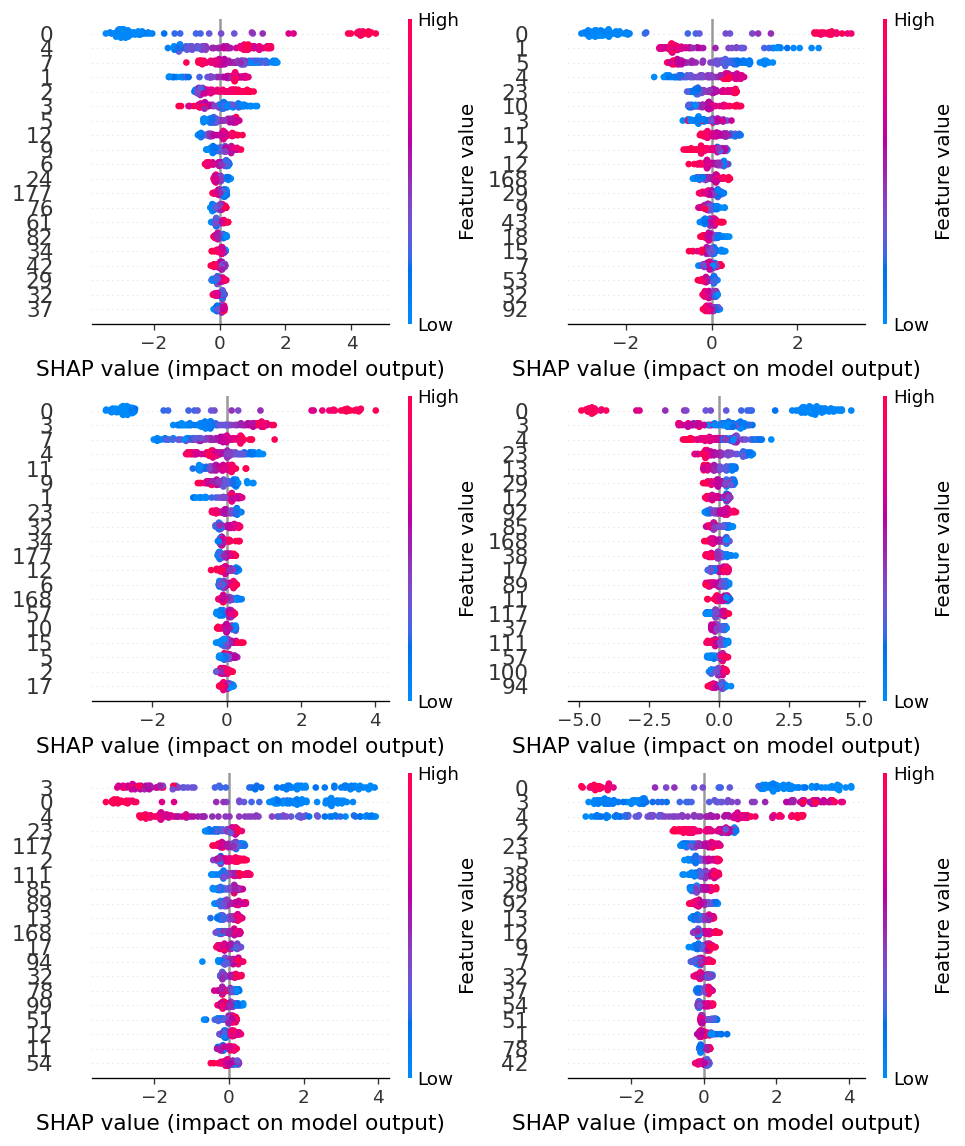

In [ ]:
plt.figure(figsize=[12, 10], dpi=120)
plt.subplot(3,2,1)
shap.summary_plot(shap_values[..., 0], X_train_pca[:100], show=False, feature_names=features)
plt.subplot(3,2,2)
shap.summary_plot(shap_values[..., 1], X_train_pca[:100], show=False, feature_names=features)
plt.subplot(3,2,3)
shap.summary_plot(shap_values[..., 2], X_train_pca[:100], show=False, feature_names=features)
plt.subplot(3,2,4)
shap.summary_plot(shap_values[..., 3], X_train_pca[:100], show=False, feature_names=features)
plt.subplot(3,2,5)
shap.summary_plot(shap_values[..., 4], X_train_pca[:100], show=False, feature_names=features)
plt.subplot(3,2,6)
shap.summary_plot(shap_values[..., 5], X_train_pca[:100], show=False, feature_names=features)
plt.show()

Как можно заметить, наибольшее влияние имеют фичи 0, 3 и 4.
- Фича 0 имеет наибольшее влияние на 5 графиках из 6. Что характерно, для 4-6 чем больше значение этой функции, тем меньшее влияние она оказывает, а чем меньше значение, тем больше влияние. Для графиков все 1-3 наоборот: чем больше значение фичи 0, тем больше влияние.
-  Фича 3 в 3, 6 имеет тем больше влияние, чем она больше, в 4 и 5 же тем больше влияение, чем она меньше.
- Фича 4 в 2, 4-6 ведет себя схоже с фичей 3, оказывает примерно такое же по масштабу влияение, в то время как для 1, 3 они, можно сказать, находятся в противофазах, то есть, когда фича 3 влияет сильнее, фича 4 почти не оказывает влияния и наоборот.
- Также для 2 значимой фичей является первая, а для 1 и 3 седьмая.  

### Conclusion

Your thoughts about the plots and model behaviour:

Смотрите выше.